In [357]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [358]:
def fire(Solution, n_x, dx, fire_starting_point_x, fir_radius):
    ST, SG = np.split(Solution, 2)
    fire_starting_index_x = int(fire_starting_point_x / dx)
    X = np.arange(n_x+1)
    distance = np.abs(X - fire_starting_index_x)
    mask = distance <= fir_radius/dx
    ST[mask] = 0.0
    SG[mask] = 0.0
    return np.concatenate((ST, SG))

In [359]:
"""x_min = 0	
x_max = 1
y_min = 0
y_max = 1
n_x = 100
n_y = 100
dx = (x_max - x_min) / n_x
dy = (y_max - y_min) / n_y
x = np.linspace(x_min, x_max, n_x)
y = np.linspace(y_min, y_max, n_y)

# Initial conditions
ST = np.ones((n_x+1, n_y+1))
SG = 2*np.ones((n_x+1, n_y+1))

S = np.concatenate((ST, SG))"""

def fire2D(Solution, fire_starting_point_x, fire_starting_point_y, fir_radius):
    ST, SG = np.split(Solution, 2)
    fire_starting_index_x = int(fire_starting_point_x / dx)
    fire_starting_index_y = int(fire_starting_point_y / dy)
    
    X, Y = np.meshgrid(np.arange(n_x+1), np.arange(n_y+1))
    distance = np.hypot(X - fire_starting_index_x, Y - fire_starting_index_y)
    mask = np.logical_and(distance <= fir_radius/dx, distance >= 0)
    ST[mask] = 0
    SG[mask] = 0
    return np.concatenate((ST, SG))

"""T = fire2D(S, 0.5, 0.5, 0.1)
ST, SG = np.split(T, 2)

plt.imshow(ST, cmap='hot', interpolation='nearest')
plt.legend()
plt.colorbar()
plt.show()

plt.imshow(SG, cmap='hot', interpolation='nearest')
plt.legend()
plt.colorbar()
plt.show()"""

"T = fire2D(S, 0.5, 0.5, 0.1)\nST, SG = np.split(T, 2)\n\nplt.imshow(ST, cmap='hot', interpolation='nearest')\nplt.legend()\nplt.colorbar()\nplt.show()\n\nplt.imshow(SG, cmap='hot', interpolation='nearest')\nplt.legend()\nplt.colorbar()\nplt.show()"

Converged after 12 iterations.


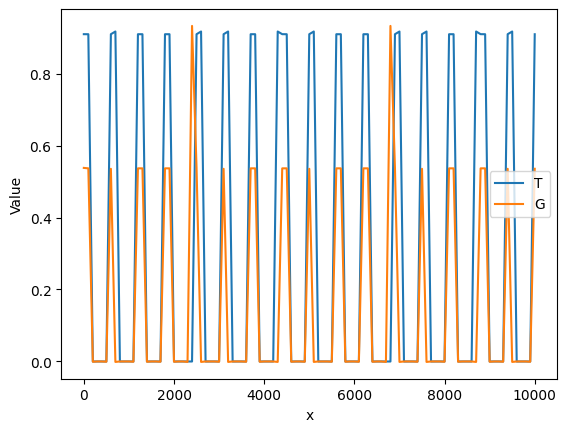

Converged after 2 iterations.


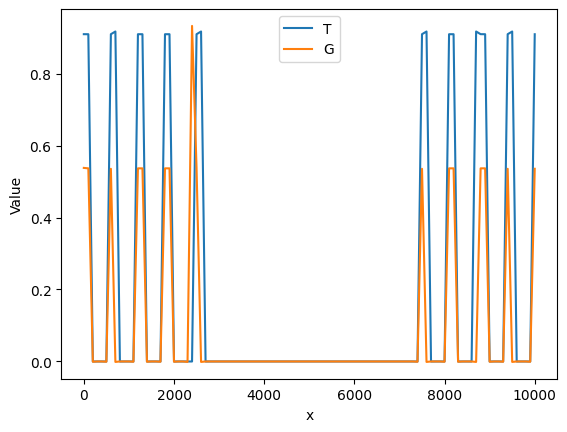

In [360]:
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

p_1 = 0.083
p_2 = 0.014
p_3 = 0.638
p_4 = 0.042
p_5 = 8
p_6 = 0.278

L = 10000
n = 100
x_min = 0
x_max = L
delta_x = (x_max - x_min) / n

def f(T, G):
    # Generate the system of equations in T
    equations_T = [T[i] * (1 - T[i]) - p_1 * T[i] + (T[i+1] - 2 * T[i] + T[i-1]) / delta_x**2 - p_2 * T[i] * G[i] for i in range(1, n)]
    i = 0
    equations_T.insert(0, T[i] * (1 - T[i]) - p_1 * T[i] + (2 * T[i+1] - 2 * T[i]) / delta_x**2 - p_2 * T[i] * G[i])  # Equation for i = 0    
    i = n
    equations_T.append(T[i] * (1 - T[i]) - p_1 * T[i] + (2 * T[i-1] - 2 * T[i]) / delta_x**2 - p_2 * T[i] * G[i])  # Equation for i = n      

    # Generate the system of equations in G
    equations_G = [p_3 * G[i] * (1 - G[i]) - p_4 * G[i] + p_5 * (G[i+1] - 2 * G[i] + G[i-1]) / delta_x**2 - p_6 * T[i] * G[i] for i in range(1, n)]
    i = 0
    equations_G.insert(0, p_3 * G[i] * (1 - G[i]) - p_4 * G[i] + p_5 * (2 * G[i+1] - 2 * G[i]) / delta_x**2 - p_6 * T[i] * G[i])  # Equation for i = 0    
    i = n
    equations_G.append(p_3 * G[i] * (1 - G[i]) - p_4 * G[i] + p_5 * (-2 * G[i] + 2 * G[i-1]) / delta_x**2 - p_6 * T[i] * G[i])  # Equation for i = n      
    return equations_T + equations_G

def J_eq_1_T(T, G):
    # Generate the Jacobian matrix
    jac_matrix = np.zeros((n+1, n+1))
   
    for i in range(1, n):
        jac_matrix[i, i] = 1 - 2 * T[i] - p_1 - 2 / delta_x**2 - p_2 * G[i]
        jac_matrix[i, i-1] = 1 / delta_x**2
        jac_matrix[i, i+1] = 1 / delta_x**2

    # Jacobian for i = 0
    i = 0
    jac_matrix[i, i+1] = 2 / delta_x**2
    jac_matrix[i, i] = 1 - 2 * T[i] - p_1 - 2 / delta_x**2 - p_2 * G[i]
   
    # Jacobian for i = n
    i = n
    jac_matrix[i, i-1] = 2 / delta_x**2
    jac_matrix[i, i] = 1 - 2 * T[i] - p_1 - 2 / delta_x**2 - p_2 * G[i]

    return jac_matrix

def J_eq_1_G(T, G):
    # Generate the Jacobian matrix
    jac_matrix = np.zeros((n+1, n+1))
    for i in range(0, n+1):
        jac_matrix[i, i] = -p_2 * T[i]
    return jac_matrix

def J_eq_2_T(T, G):
    # Generate the Jacobian matrix
    jac_matrix = np.zeros((n+1, n+1))
    for i in range(0, n+1):
        jac_matrix[i, i] = -p_6 * G[i]
    return jac_matrix

def J_eq_2_G(T, G):
    # Generate the Jacobian matrix
    jac_matrix = np.zeros((n+1, n+1))
   
    for i in range(1, n):
        jac_matrix[i, i] = p_3 - 2 * p_3 * G[i] - p_4 - 2 * p_5 / delta_x**2 - p_6 * T[i]
        jac_matrix[i, i-1] = p_5 / delta_x**2
        jac_matrix[i, i+1] = p_5 / delta_x**2

    # Jacobian for i = 0
    i = 0
    jac_matrix[i, i+1] = (2 * p_5) / delta_x**2
    jac_matrix[i, i] = p_3 - 2 * p_3 * G[i] - p_4 - 2 * p_5 / delta_x**2 - p_6 * T[i]
   
    # Jacobian for i = n
    i = n
    jac_matrix[i, i-1] = (2 * p_5) / delta_x**2
    jac_matrix[i, i] = p_3 - 2 * p_3 * G[i] - p_4 - 2 * p_5 / delta_x**2 - p_6 * T[i]

    return jac_matrix

def J(T, G):
    Jac_eq_1_T = J_eq_1_T(T, G)
    Jac_eq_1_G = J_eq_1_G(T, G)
    Jac_eq_2_T = J_eq_2_T(T, G)
    Jac_eq_2_G = J_eq_2_G(T, G)

    # Create a larger matrix to hold the combined result
    Jac = np.zeros((2 * (n+1), 2 * (n+1)))
   
    # Insert matrices into appropriate positions
    Jac[:n+1, :n+1] = Jac_eq_1_T  # Left upper part
    Jac[:n+1, n+1:] = Jac_eq_1_G  # Right upper part
    Jac[n+1:, :n+1] = Jac_eq_2_T  # Left lower part
    Jac[n+1:, n+1:] = Jac_eq_2_G  # Right lower part
   
    return Jac



def newton_raphson_system(f, J, initial_guess, tol=1e-6, max_iter=100):
    for i in range(max_iter):
        # Split initial guess into T and G
        T, G = np.split(initial_guess, 2)

        # Evaluate the system of equations and the Jacobian at the current point
        f_val = np.array(f(T, G))
        J_val = np.array(J(T, G))

        # Solve the linear system to get the update
        delta_T_G = spsolve(J_val, -f_val)
       
        # Update the solution
        initial_guess += delta_T_G
        #print(delta_T_G)
        # Check for convergence
        if np.linalg.norm(delta_T_G) < tol:
            print('Converged after', i + 1, 'iterations.')
            return initial_guess  # Return the solution
   
    raise RuntimeError("Newton-Raphson method did not converge within the maximum number of iterations.")




# Initial guess
x = np.linspace(x_min, x_max, n+1)

initial_guess = np.zeros(2*(n + 1))
for i in range(0,n+1):
    initial_guess[i] = 0.909*np.cos(i)
   
for i in range(n+1, 2*(n+1)):
    initial_guess[i] = 0.538*np.cos(i)
   

T, G = np.split(initial_guess, 2)
Jac = J(T,G)


# Solve the system
solution = newton_raphson_system(f, J, initial_guess)


T_solution, G_solution = np.split(solution, 2)


# Plot the results
x = np.linspace(x_min, x_max, n+1)

plt.figure()
plt.plot(x, T_solution, label='T')
plt.plot(x, G_solution, label='G')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.show()

afterfire = fire(solution, n, delta_x, 5000, 2000)


initial_guess_2 = afterfire.copy()
T, G = np.split(initial_guess_2, 2)
Jac = J(T,G)

solution = newton_raphson_system(f, J, initial_guess_2)



# Split solution into T and G
T_solution, G_solution = np.split(solution, 2)



# Plot the results
x = np.linspace(x_min, x_max, n+1)

plt.figure()
plt.plot(x, T_solution, label='T')
plt.plot(x, G_solution, label='G')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.show()
